# Queue Estimation on LLMs

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import re

In [2]:
data_dir = "data_25Nov"

In [3]:
def get_lam(C, w):
    """compute lambda in requests per second"""
    return float(C*1_000_000/w)
    
def get_fname_frag_for_exp(MB, C, w, t, n, d):
    """make name fragment for the CSV files of that experiment"""
    return f'MB_{MB}_C{C}_w{w}_t{t}_n{n}_d{d}'

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def trim(df):
    n = len(df)
    m = max(2, int(0.05*n))
    M = min(n-2, int(0.95*n))
    df1 = df.loc[m:M]
    return df1

def load_dfs(MB, C, w, t, n, d):
    exp_str = get_fname_frag_for_exp(MB, C, w, t, n, d)
    q_fname = f'{data_dir}/queue_size_{exp_str}.csv'
    print(f'Reading from {q_fname}')
    q_df = pd.read_csv(q_fname, parse_dates=['timestamp'])
    q_df = trim(q_df)
    q_df.index = normalize(q_df['timestamp'].astype(int))
    q_df['in_service'] = q_df.queue_size + q_df.batch_current_size
    if C > 1:
        r_fnames = [f'{data_dir}/round_trips_{exp_str}_{i}.csv' for i in range(1, C+1)]
        print(f'Reading from {r_fnames}')        
        r_dfs = [pd.read_csv(r_fname, names=['i', 'start', 'end', 'rtt', 'ok']) for r_fname in r_fnames]
        r_df = pd.concat(r_dfs, ignore_index=True)
    else:
        r_fname = f'{data_dir}/round_trips_{exp_str}.csv'
        print(f'Reading from {r_fname}')
        r_df = pd.read_csv(r_fname, names=['i', 'start', 'end', 'rtt', 'ok'])
    r_df = trim(r_df)
    return exp_str, q_df, r_df

def extract_cq_df(r_df):
    starts = r_df.start.sort_values()
    ends = r_df.end.sort_values()
    cq = []
    for t in starts:
        cq.append([t, 1])
    for t in ends:
        cq.append([t, -1])
    cq = sorted(cq, key=lambda r: r[0])
    cq_df = pd.DataFrame(data=cq, columns=['time', 'd'])
    cq_df.index = normalize(cq_df['time'])
    cq_df['q'] = cq_df['d'].cumsum()
    return cq_df

def title_from_exp_str(frag):
    # Replace underscores with spaces
    s = frag.replace('_', ' ')
    
    # Insert '=' between letters and numbers
    s = re.sub(r'([a-zA-Z])(\d+)', r'\1=\2', s)
    
    # Add commas to large numbers (1,000 and above)
    s = re.sub(r'(\d{1,3})(?=(\d{3})+(?!\d))', r'\1,', s)
    return s


In [4]:
def plot_queues(q_df, cq_df, exp_str):
    mean_in_service = q_df['in_service'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(q_df.index, q_df['in_service'], label='In System')
    plt.plot(q_df.index, q_df['batch_current_size'], label='Current Batch')
    plt.plot(cq_df.index, cq_df['q'], label='From client side')
    plt.axhline(y=mean_in_service, color='green', linestyle='--', label=f'Mean ({mean_in_service:.2f})')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Requests in Service')
    plt.title(title_from_exp_str(exp_str))
    ax = plt.gca()
    ax.set_ylim(0, int(q_df['in_service'].max()) + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=8))

    plt.legend()
    plt.tight_layout()

def plot_input_rate(q_df, lam, exp_str):
    mean_request_rate = q_df['request_rate'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(q_df.index, q_df['request_rate'], label=r'Observed Requests Rate $\lambda$')
    plt.axhline(y=mean_request_rate, color='green', linestyle='--', label=f'Mean ({mean_request_rate:.2f})')
    plt.axhline(y=lam, color='orange', linestyle=':', label=f'True value ({lam:.2f})')
    
    plt.xlabel('Timestamp')
    plt.ylabel(r'Observed Request Rate $\lambda$')
    plt.title(title_from_exp_str(exp_str))
    plt.legend()
    plt.tight_layout()

def plot_estimated_mu(mu_hat, r_df, exp_str):
    mean_mu_hat = mu_hat.mean()
    rtt_mean = r_df['rtt'].mean()
    per_req_mean = 1 / rtt_mean
    plt.figure(figsize=(10, 6))
    plt.plot(mu_hat, label=r'Estimated Service Rate $\hat{\mu}$')
    plt.axhline(y=mean_mu_hat, color='green', linestyle='--', label=f'Mean ({mean_mu_hat:.2f})')
    # plt.axhline(y=per_req_mean, color='orange', linestyle=':', label=f'Client Observed ({per_req_mean:.2f})')
    plt.ylim((0,None))
    plt.xlabel('Timestamp')
    plt.ylabel(r'Estimated Service Rate $\hat{\mu}$')
    plt.title(title_from_exp_str(exp_str))
    plt.legend()
    plt.tight_layout()


In [5]:
def estimate_mu(q_df, lam, MB):
    mu_hat = -1/d * q_df['in_service'].diff() + lam
    mu_hat = mu_hat.dropna()
    return mu_hat

# MB=1 C=1 w=800_000 t=800 n=60 d=5

In [6]:
MB=1
C=1
w=800_000
t=800
n=60
d=5

In [7]:
lam = get_lam(C, w)

In [8]:
exp_str, q_df, r_df = load_dfs(MB, C, w, t, n, d)

Reading from data_25Nov/queue_size_MB_1_C1_w800000_t800_n60_d5.csv
Reading from data_25Nov/round_trips_MB_1_C1_w800000_t800_n60_d5.csv


In [9]:
cq_df = extract_cq_df(r_df)

In [10]:
mu_hat = estimate_mu(q_df, lam, MB)

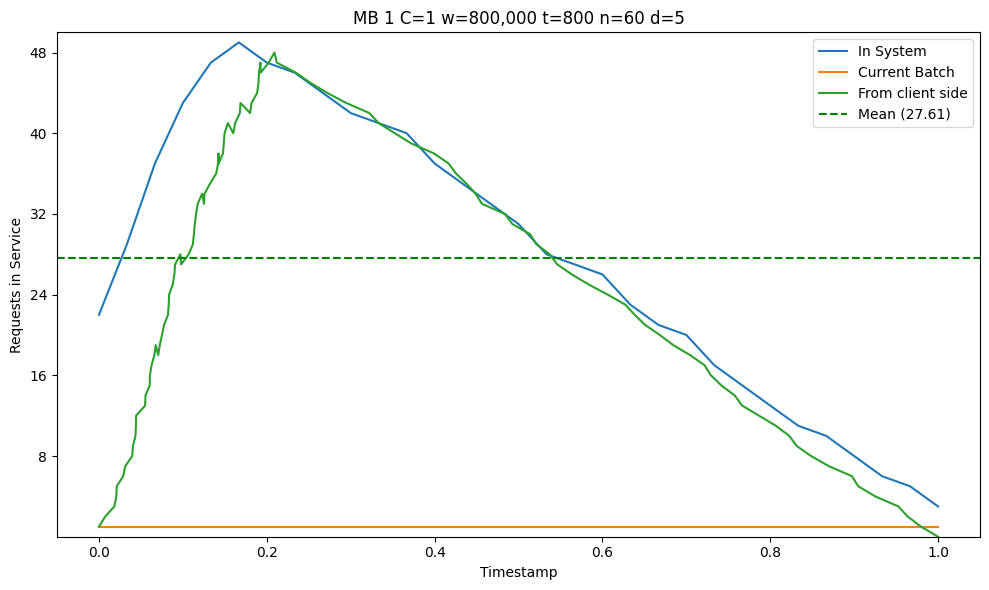

In [11]:
plot_queues(q_df, cq_df, exp_str)

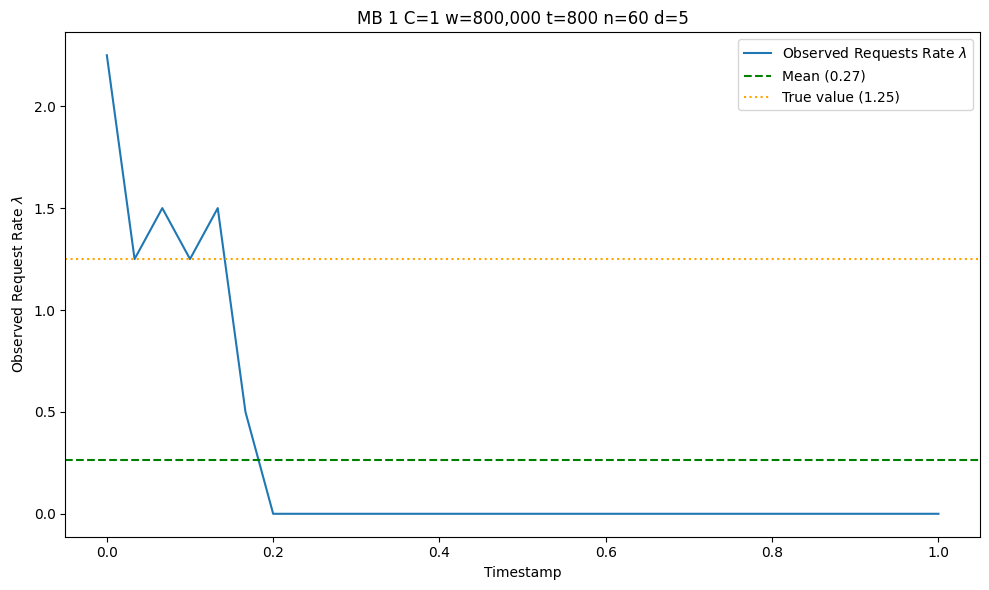

In [12]:
plot_input_rate(q_df, lam, exp_str)

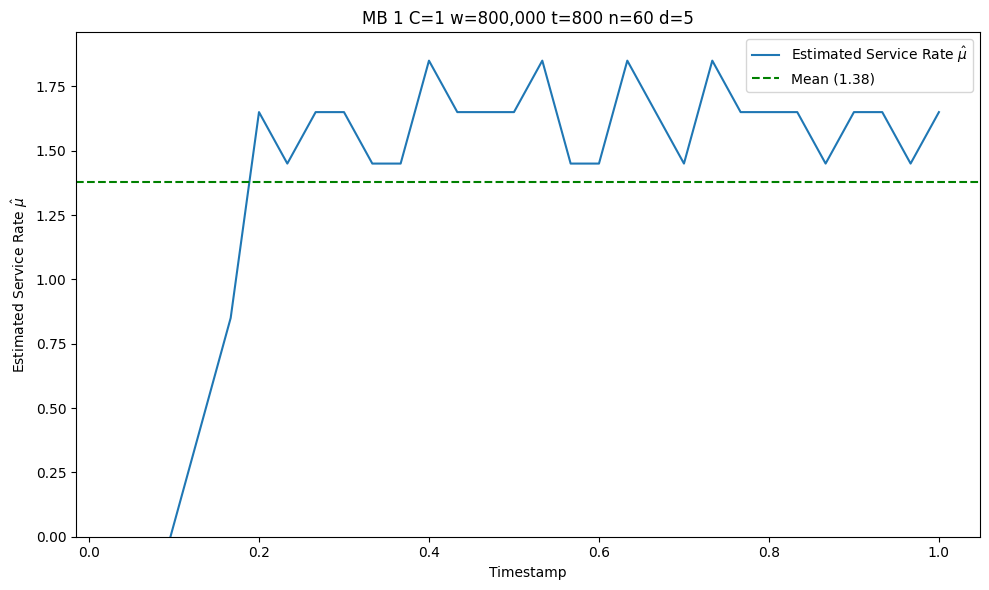

In [13]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=1 C=1 w=800_000 t=1600 n=60 d=5

In [14]:
MB=1
C=1
w=800_000
t=1600
n=60
d=5

In [15]:
lam = get_lam(C, w)

In [16]:
exp_str, q_df, r_df = load_dfs(MB, C, w, t, n, d)

Reading from data_25Nov/queue_size_MB_1_C1_w800000_t1600_n60_d5.csv
Reading from data_25Nov/round_trips_MB_1_C1_w800000_t1600_n60_d5.csv


In [17]:
cq_df = extract_cq_df(r_df)

In [18]:
mu_hat = estimate_mu(q_df, lam, MB)

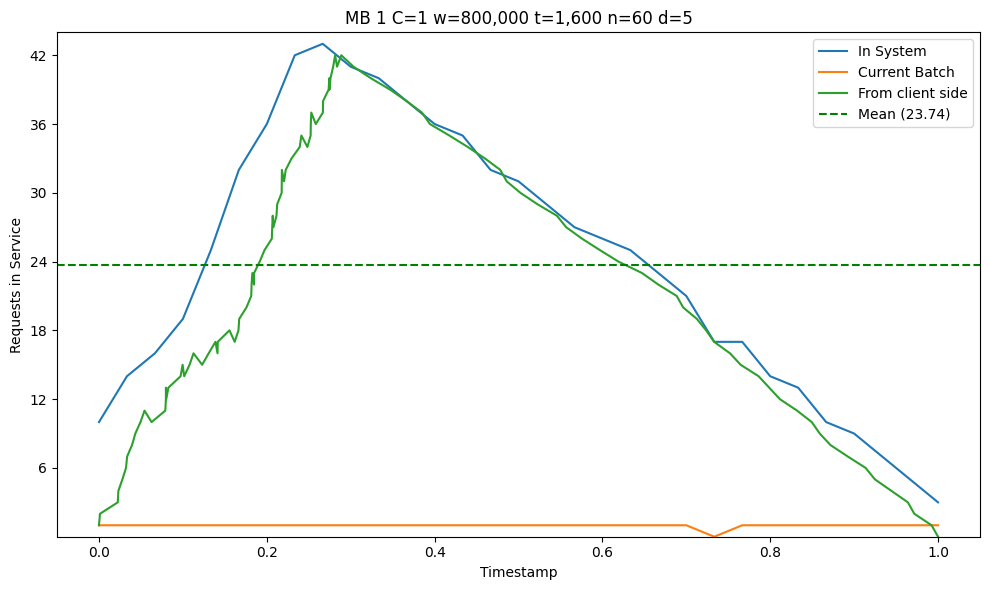

In [19]:
plot_queues(q_df, cq_df, exp_str)

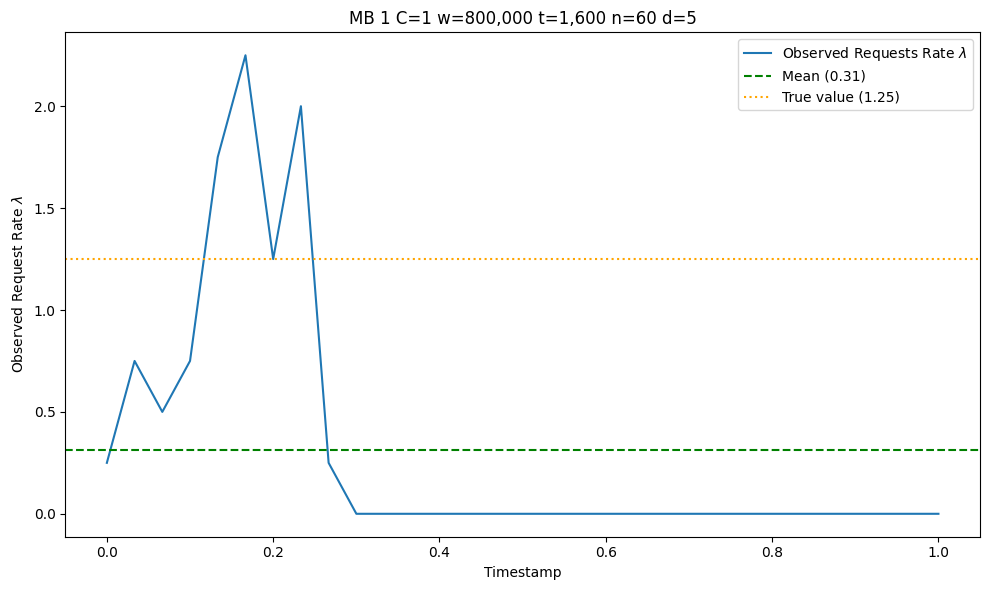

In [20]:
plot_input_rate(q_df, lam, exp_str)

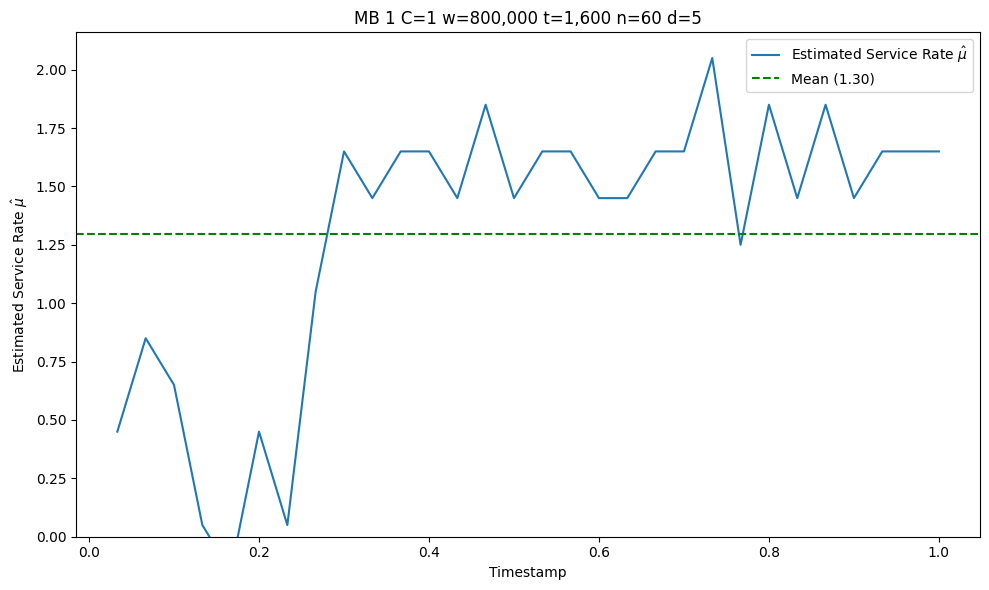

In [21]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=4 C=1 w=800_000 t=1600 n=60 d=5

In [22]:
MB=4
C=1
w=800_000
t=1600
n=60
d=5

In [23]:
lam = get_lam(C, w)

In [24]:
exp_str, q_df, r_df = load_dfs(MB, C, w, t, n, d)

Reading from data_25Nov/queue_size_MB_4_C1_w800000_t1600_n60_d5.csv
Reading from data_25Nov/round_trips_MB_4_C1_w800000_t1600_n60_d5.csv


In [25]:
cq_df = extract_cq_df(r_df)

In [26]:
mu_hat = estimate_mu(q_df, lam, MB)

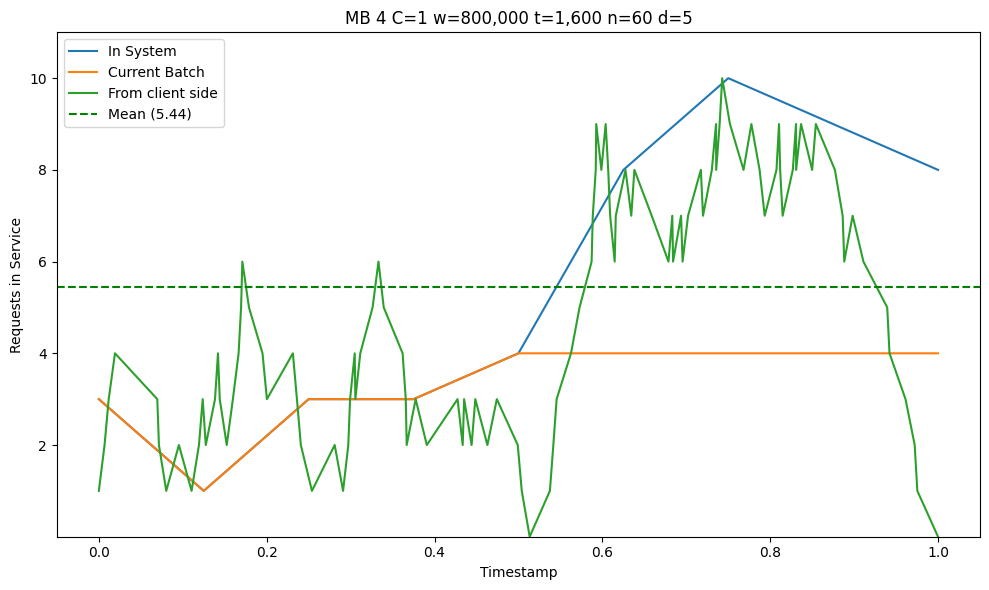

In [27]:
plot_queues(q_df, cq_df, exp_str)

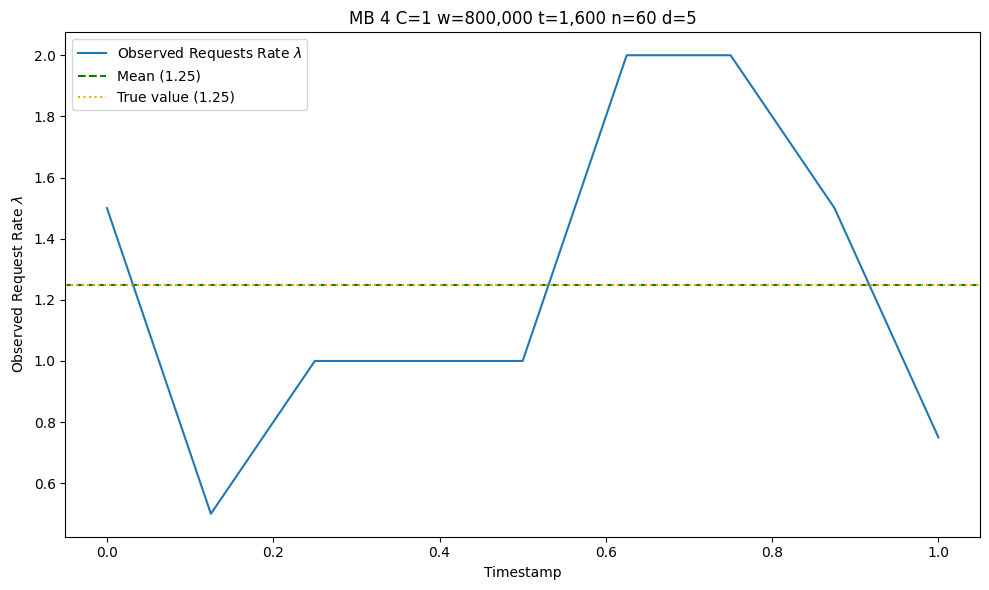

In [28]:
plot_input_rate(q_df, lam, exp_str)

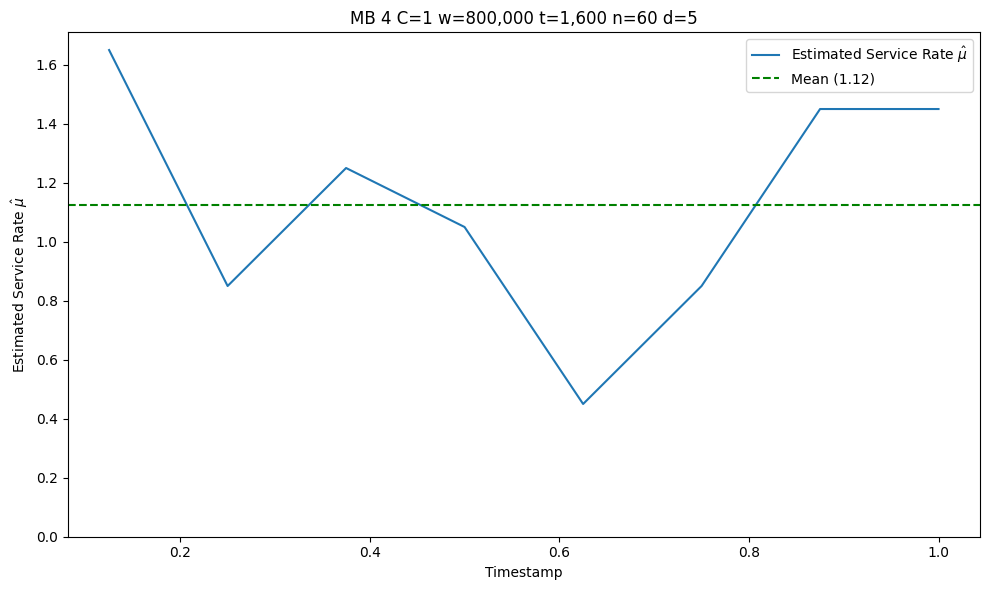

In [29]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=16 C=1 w=800_000 t=1600 n=60 d=5

In [30]:
MB=16
C=1
w=800_000
t=1600
n=60
d=5

In [31]:
lam = get_lam(C, w)

In [32]:
exp_str, q_df, r_df = load_dfs(MB, C, w, t, n, d)

Reading from data_25Nov/queue_size_MB_16_C1_w800000_t1600_n60_d5.csv
Reading from data_25Nov/round_trips_MB_16_C1_w800000_t1600_n60_d5.csv


In [33]:
cq_df = extract_cq_df(r_df)

In [34]:
mu_hat = estimate_mu(q_df, lam, MB)

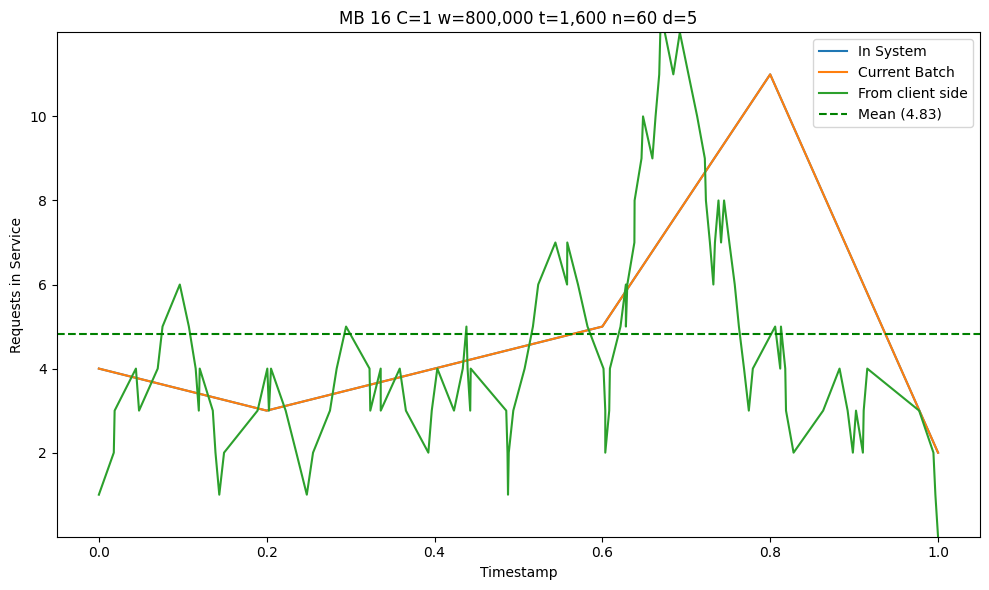

In [35]:
plot_queues(q_df, cq_df, exp_str)

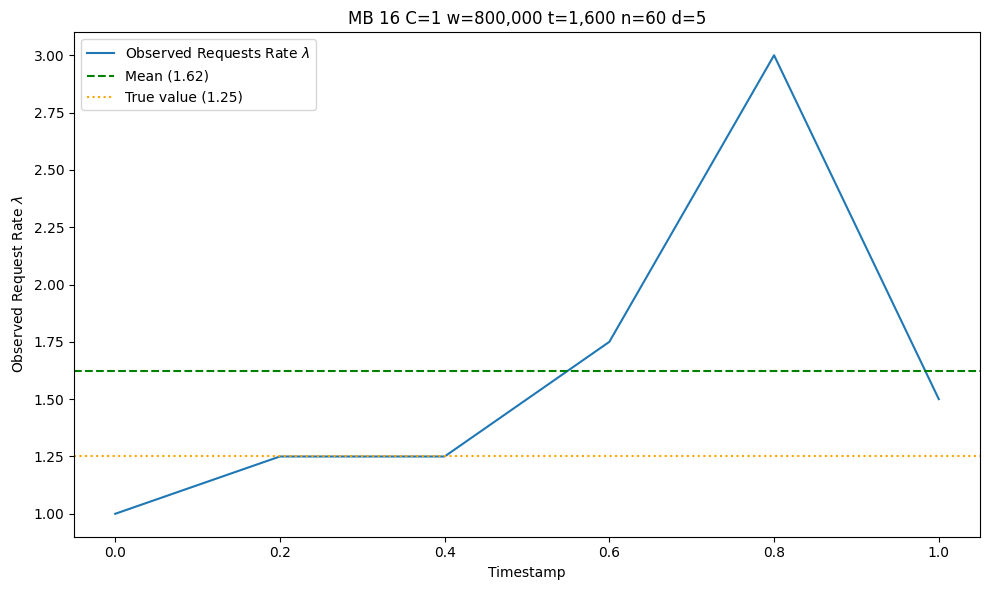

In [36]:
plot_input_rate(q_df, lam, exp_str)

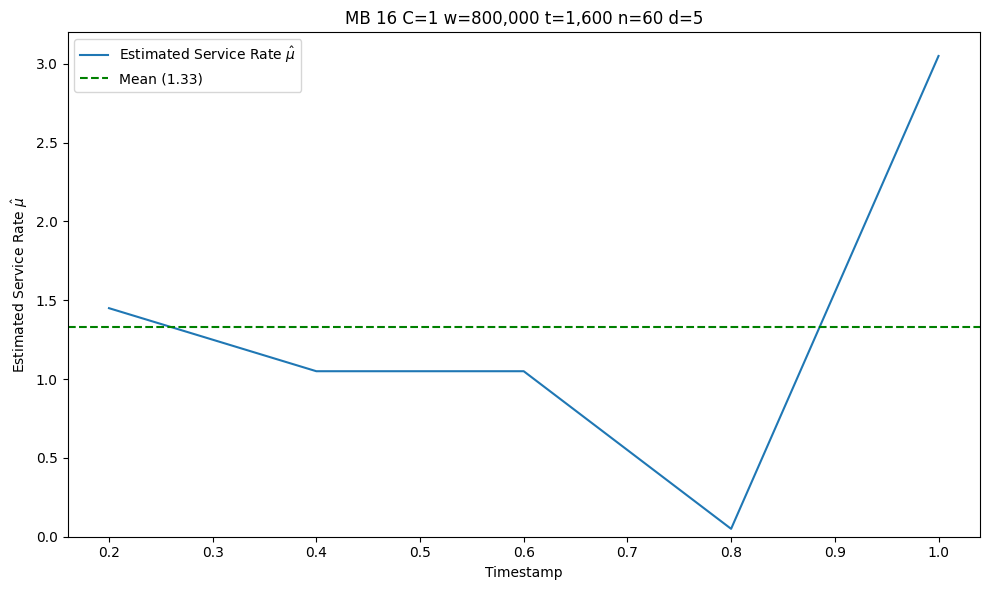

In [37]:
plot_estimated_mu(mu_hat, r_df, exp_str)

In [38]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
0.00000,2024-11-25 12:14:23.211,0.0,4.0,1.00,4.0
0.20000,2024-11-25 12:14:28.222,0.0,3.0,1.25,3.0
0.39996,2024-11-25 12:14:33.232,0.0,4.0,1.25,4.0
0.59996,2024-11-25 12:14:38.243,0.0,5.0,1.75,5.0
0.79996,2024-11-25 12:14:43.254,0.0,11.0,3.00,11.0
